## Diversity score verification

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from datasets import load_dataset, Dataset
import random
import numpy as np
from tqdm import tqdm
import os
import gc

seed =3
random.seed(seed)
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def cosDistance(sample_embedding, selected_embeddings, k_near=0):
    similarity_vector = torch.matmul(selected_embeddings, sample_embedding)
    distance_vector = 1.0 - similarity_vector
    if selected_embeddings.size(0) > k_near:
        distance_vector, _ = torch.topk(distance_vector, k=k_near, dim=0)
    mean_distance = distance_vector.mean()
    return mean_distance

def mean_pooling(model_output, attention_mask):
    
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def process_dialog(dialog):
    conversation = ""
    for message in dialog['messages']:
        conversation += f"### {message['role']}: {message['content']}\n"
    return {"features": conversation}

def embed_text(batch):
    encoded_inputs = tokenizer(batch['features'], padding=True, truncation=True, return_tensors="pt").to(device)
    if 'token_type_ids' in encoded_inputs:
        del encoded_inputs['token_type_ids']
        
    with torch.no_grad():
        model_outputs = model(**encoded_inputs)
    sentence_embeddings = mean_pooling(model_outputs, encoded_inputs['attention_mask'].to(device))
    embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    
    batch['embeddings'] = embeddings.cpu().numpy().tolist()
    return batch

##############################################################################################################################
samples = [
    {
        "messages": [
            {"role": "user", "content": "please tell me the answer of below math question '1+1=?'"},
            {"role": "assistant", "content": "answer:2"}
        ]
    },
    {
        "messages": [
            {"role": "user", "content": "please tell me the answer of below math question '1+1=?'"},
            {"role": "assistant", "content": "answer:3"}
        ]
    }
]

embedding_models = [###encoders
                    "tbs17/MathBERT",
                    "BAAI/bge-large-en-v1.5", 
                    "sentence-transformers/all-mpnet-base-v2", 
                    ##### 
                    "facebook/galactica-6.7b", 
                    "meta-llama/Llama-3.1-8B-Instruct",
                    "meta-llama/Llama-3.2-3B-Instruct",
                    "Qwen/Qwen2.5-Math-7B-Instruct",
                    "Qwen/Qwen2.5-Math-1.5B-Instruct",
                    "Qwen/Qwen2.5-14B-Instruct",
                    "mistralai/Mistral-7B-Instruct-v0.3",
                    "deepseek-ai/deepseek-math-7b-base",
                    ] # "BAAI/bge-large-en-v1.5", "sentence-transformers/all-mpnet-base-v2"

distances = {}

for embedding_model_name in embedding_models:
    print(f"### embedding model: {embedding_model_name}")
    tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
    model = AutoModel.from_pretrained(embedding_model_name).to(device)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    embeddings = []
    for sample in samples:
        dialog = process_dialog(sample)
        embeddings.append(embed_text(dialog))
        
    dist = cosDistance(torch.Tensor(embeddings[0]['embeddings'][0]), torch.Tensor(embeddings[1]['embeddings'][0]))

    distances[os.path.basename(embedding_model_name)] = round(dist.item(), 3)
    
    del model
    del tokenizer
    torch.cuda.empty_cache()
    gc.collect()

import pandas as pd

distances_df = pd.DataFrame(list(distances.items()), columns=["Model", "Distance"])
print(distances_df)


## GPT API text embedding

In [8]:
from openai import OpenAI
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from datasets import load_dataset, Dataset
import random
import numpy as np
from tqdm import tqdm
import os

api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

def cosDistance(sample_embedding, selected_embeddings, k_near=0):
    similarity_vector = torch.matmul(selected_embeddings, sample_embedding)
    distance_vector = 1.0 - similarity_vector
    if selected_embeddings.size(0) > k_near:
        distance_vector, _ = torch.topk(distance_vector, k=k_near, dim=0)
    mean_distance = distance_vector.mean()
    return mean_distance

samples = [
    {
        "messages": [
            {"role": "user", "content": "please tell me the answer of below math question '1+1=?'"},
            {"role": "assistant", "content": "answer:2"}
        ]
    },
    {
        "messages": [
            {"role": "user", "content": "please tell me the answer of below math question '1+1=?'"},
            {"role": "assistant", "content": "answer:3"}
        ]
    },
    {
        "messages": [
            {"role": "user", "content": "please tell me the answer of below math question '10+10=?'"},
            {"role": "assistant", "content": "answer:20"}
        ]
    },
    {
        "messages": [
            {'role': 'user', 'content': 'Calculate 15% of 500.\n\n'},
            {'role': 'assistant', 'content': '75'}
        ]
    },
    {
        "messages": [
            {'role': 'user', 'content': 'Calculate 50% of 300.'},
            {'role': 'assistant', 'content': '50% of 300 is 150.'}
        ]
    },
        {
        "messages": [
            {"role":"user","content":"Task: Generate an open-ended story based on the following prompts.\nInput: Prompts: False accusation, Tower, Mallet\nOutput:"},
            {"role":"assistant","content":"Once upon a time, there was a small village nestled in a meadow at the foot of a tall tower. The tower was used by the local villagers for refuge during times of trouble, and with its high walls, it was secure and impenetrable. \n\nOne day, a stranger appeared in the village without warning and accused one of the villagers of a serious crime. Perplexed and outraged, the villagers voted to conduct a trial. The stranger declared that the accused must climb to the top of the tower and if they could make it to the top with a mallet, then they would be found innocent. If they failed, then the stranger would claim that they had fled and were therefore guilty. The accused was terrified, as none had ever made it to the top before. But to their surprise, they succeeded with the aid of the mallet, and the stranger was forced to leave in shame. \nFrom then on, the villagers held a festival once a year to mark the occasion and celebrate the strength of the accused."}]
    }
]

#####################
add_system_prompt = False

embedding_models = ["text-embedding-3-small", "text-embedding-3-large", "text-embedding-ada-002"]

system_prompt = "### system: please carefully check the correctness of the assistant's answer. Reason step by step and provide the explanations." if add_system_prompt else None

tot_embeddings = {}

# example_pairs = [(0,1), (1,2), (3,4)]
example_pairs = [(0,1), (1,2), (3,4)]

for embedding_model in embedding_models:
    
    dist_pairs = []
    
    for example_pair in example_pairs:
        embeddings =[]
        for sample in samples:
            conversation = ""
            for message in sample['messages']:
                conversation += f"{system_prompt} ### {message['role']}: {message['content']}\n"
            response = client.embeddings.create(
                input=conversation,
                model=embedding_model,
            )
            embeddings.append(response.data[0].embedding)
            
        # print(response.data[0].embedding)
        emb1 = torch.Tensor(embeddings[example_pair[0]])
        emb2 = torch.Tensor(embeddings[example_pair[1]])
        dist = cosDistance(emb1, emb2)
        dist_pairs.append(round(dist.item(), 4))
        # print(f"GPT embedding model: {embedding_model}")
        # print(f"cos distance: {round(dist.item(), 4)}\n")
        
    tot_embeddings[embedding_model] = dist_pairs
        

import pandas as pd

pair_names = [f"Pair {p[0]}-{p[1]}" for p in example_pairs]  
tot_embeddings_df = pd.DataFrame.from_dict(tot_embeddings, orient='index', columns=pair_names)

print(tot_embeddings_df)


                        Pair 0-1  Pair 1-2  Pair 3-4
text-embedding-3-small    0.0208    0.1380    0.1415
text-embedding-3-large    0.0490    0.2043    0.2464
text-embedding-ada-002    0.0050    0.0487    0.0697


In [14]:
conversation

"### system: please carefully check the correctness of the assistant's answer. Reason step by step and provide the explanations. ### user: please tell me the answer of below math question '1+1=?'\n### system: please carefully check the correctness of the assistant's answer. Reason step by step and provide the explanations. ### assistant: answer:3\n"

|      Model            | Example 1 & 2 | Example 2 & 3 | Example 4 & 5 |
|-------------------------|---------------|---------------|---------------|
| GPT text-embedding-3-small  | 0.0208        | 0.1380        | 0.1415        |
| GPT text-embedding-3-large  | 0.0490        | 0.2043        | 0.2464        |
| GPT text-embedding-ada-002  | 0.0050        | 0.0487        | 0.0697        |
|bge-large-en-v1.5 (used) |  0.00772 | 0.04975 | 0.09283 |


In [1]:
import torch
import fire
import os
import json
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import accelerate
from functools import partial
from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm
import numpy as np
from accelerate.utils import is_xpu_available
from accelerate import Accelerator
import regex as re
from datasets import load_dataset
import sys
import gc

### store the model 
os.environ["TOKENIZERS_PARALLELISM"] = "false"
B_INST, E_INST = "[INST]", "[/INST]"


class CustomDataset(Dataset):
    def __init__(self, dataset_name, dialogs, template=None):
        self.dataset_name = dataset_name
        self.dialogs = dialogs
        self.template = template
    def __getitem__(self, idx):

        return {'data': self.dialogs[idx], 'index': idx}
    
    def __len__(self):
        return len(self.dialogs)
    
    def map(self, function):
        self.dialogs = [function(item, self.template) for item in self.dialogs]
        return self
    


system_prompt = '''As a data quality estimator, your task is to assess the quality of data sample based on the criteria: Rarity, Complexity, Informativeness.
    Please rate the sample on a scale from 1 to 10 for each criterion, and return an overall rating on a scale from 1 to 10, where a higher score indicates higher level of quality.
    Ensure that the ratings are not overly concentrated around a specific score. If multiple samples have similar qualities, consider spreading the scores more evenly to reflect subtle differences.
    '''

user_prompt ='''Now, please carefully evaluate the following data sample and return the integral evaluation scores using the JSON format:
    {
        "Rarity": <number, 1-10>,
        "Complexity": <number, 1-10>,
        "Informativeness": <number, 1-10>,
        "Overall rating": <number, 1-10>
    }
    Remember: the output must strictly follow this format, without any deviations.
    '''   
    
# # mistral
# model_name = "mistralai/Mistral-7B-Instruct-v0.3"
# prompt_template = '''
#             <s>[INST]system{}[/INST]
#             [INST]user{} \n## Data sample (conversation):\n{}[/INST]
#             [INST]assistant
#             '''    



###llama
model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
prompt_template = '''
            <|begin_of_text|><|start_header_id|>system<|end_header_id|>{}<|eot_id|>
            <|start_header_id|>user<|end_header_id|>{} \n## Data sample (conversation):\n{}<|eot_id|> 
            <|start_header_id|>assistant<|end_header_id|>
            '''


# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
# Load the model
model = AutoModelForCausalLM.from_pretrained(model_name, device_map='auto')


dataset_name='test'
print(f"Loading dataset: {dataset_name}")
data = load_dataset('json', data_files=f'../{dataset_name}_data.jsonl')

print("Preprocessing dataset...")
inputs= []
dialogs = data['train']
for dialog in dialogs:
    conversation = ""
    for message in dialog['messages']:  #[{{'role': 'user', 'content': 'blabla'}, {'role': 'assistant', 'content': 'blabla'}]
        conversation += f"### {message['role']}: {message['content']}\n"
    inputs.append(prompt_template.format(system_prompt, user_prompt, conversation))


print(inputs)

dataset = CustomDataset(dataset_name, inputs)

data_loader = DataLoader(dataset, batch_size=8, shuffle=False) #, shuffle=True, seed=42 




# Example: encode a prompt and generate a response

output_text_all = []
output_labels = []
results = [] #store the results for data parallel

model.eval()
rating_all = []

json_pattern = re.compile(r'\{(?:[^{}]|(?R))*\}')


for batch in tqdm(data_loader, desc="Generating inference info for answers"):

    batch_data = batch['data']
    batch_indices = batch['index'] #record the index for each sample to maintain the sequence

    encodings = tokenizer(batch_data, padding=True, max_length=2048, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model.generate(
            input_ids=encodings['input_ids'],
            attention_mask=encodings['attention_mask'],
            max_new_tokens=128,
            do_sample=True,
            top_p=0.9,
            temperature=1,
            use_cache=False,
            top_k=50,
            repetition_penalty=1,
            length_penalty=1,
        )

    output_text_batch = [tokenizer.decode(x, skip_special_tokens=True) for x in outputs]
    rating_batch = [None] * len(batch_data)
    for idx, output_text in enumerate(output_text_batch):
        # print("="*50 + "\n")
        # print(output_text)   
        # print("="*50 + "\n")

        retry_count = 50
        try:
            while retry_count>0:
                matches = json_pattern.findall(output_text)
                if matches:
                    try:
                        # extract the json object
                        json_obj = json.loads(matches[-1])
                        # rating_batch[idx] = json.dumps(json_obj)
                        rating_batch[idx] = [int(json_obj['Rarity']), int(json_obj['Complexity']), int(json_obj['Informativeness']), int(json_obj['Overall rating'])]
                        break  
                    except json.JSONDecodeError:
                        print(f"JSON Decode Error for batch data {batch_indices[idx]}")
                else:
                    print(f"No JSON match for batch data {batch_indices[idx]}, recalculating...")

                    with torch.no_grad():
                        single_output = model.generate(
                            input_ids=encodings['input_ids'],
                            attention_mask=encodings['attention_mask'],
                            max_new_tokens=128,
                            do_sample=True,
                            top_p=0.9,
                            temperature=1,
                            use_cache=False,
                            top_k=50,
                            repetition_penalty=1,
                            length_penalty=1,
                        )

                    output_text = tokenizer.decode(single_output[0], skip_special_tokens=True)
                retry_count -= 1
                
        except Exception as exc:
            print(f'{batch_indices[idx]} generated an exception: {exc}')

        results.append((batch_indices[idx], rating_batch[idx] if rating_batch[idx] is not None else [0,0,0,0]))

        rating_all.extend(rating_batch)
        print(f"Unlabeled samples size of each batch: {rating_batch.count(None)}")

    del encodings, output_text_batch, batch
    torch.cuda.empty_cache()


print(f"All unlabeled samples: {rating_all.count(None)}")

from collections import Counter
rating_all_revise = [rating[-1] for rating in rating_all if rating is not None]
print(f"Score distribution: {Counter(rating_all_revise)}")



label_all = [label[-1] for label in output_labels]
print(f"Final scores: {label_all}")

print(f"Final score distribution: {Counter(label_all)}")




/home/jlpang/LLM_data_selection/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


OSError: [Errno 28] No space left on device

## calculate the long tail score distribution

/home/jlpang/LLM_data_selection/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_3505385/572632108.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start s

==== Docta: Doctor for your data. Current version: 0.2 ====


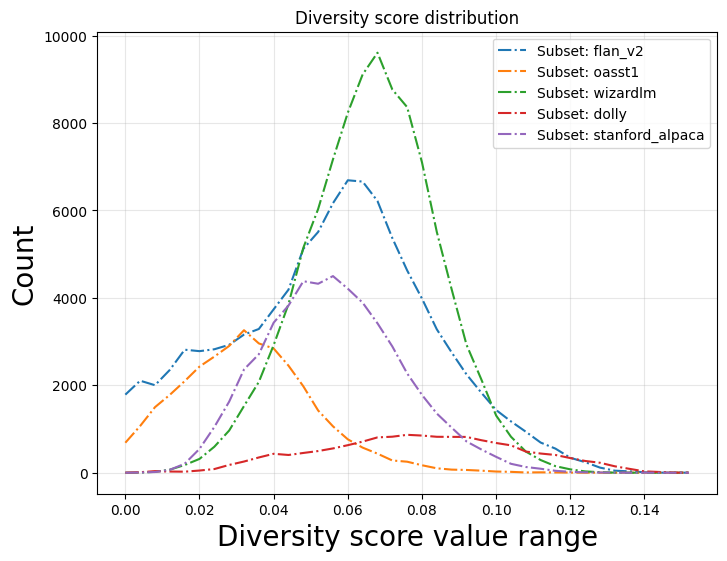

In [1]:
import os
from datasets import load_dataset, concatenate_datasets
import torch
import numpy as np
import matplotlib.pyplot as plt

dataset_name='all_train'
model_name="meta-llama/Meta-Llama-3.1-8B-Instruct"
dataset_size =10000
# list = ['flan_v2', 'oasst1', 'wizardlm', 'dolly', 'stanford_alpaca']

report_path = f"./results-embedding-model-bge/{model_name}/{dataset_name}/{dataset_name}_report.pt"
reports = torch.load(report_path)

subsets = {'flan_v2': 100000, 'oasst1': 33919, 'wizardlm': 100000, 'dolly':15011, 'stanford_alpaca':52002}



rare_samples = reports.detection['rare_example'][:len(reports.detection['rare_example'])//2]

long_tail_scores = [sample[-1]  for sample in rare_samples]
bins = np.arange(0, max(long_tail_scores) + 0.004, 0.004)
plt.figure(figsize=(8, 6))

count = 0
# for key, value in subsets.items():
#     sub_long_tail_scores = long_tail_scores[count: count+value]
#     # counts, _ = np.histogram(sub_long_tail_scores, bins)
#     count += value
#     plt.hist(sub_long_tail_scores, bins, alpha=0.5, label=f'Subset: {key}', edgecolor='gray')

for key, value in subsets.items():
    sub_long_tail_scores = long_tail_scores[count: count+value]
    counts, _ = np.histogram(sub_long_tail_scores, bins)
    count += value
    plt.plot(bins[:-1], counts, alpha=1, linestyle='-.', label=f'Subset: {key}')
    

    
plt.grid(alpha=0.3, linestyle='-')
plt.title('Diversity score distribution')
plt.xlabel('Diversity score value range', fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend(loc='upper right', fontsize=20)
plt.show()



## Evaluate the diversity score's performance

In [16]:
import os
from datasets import load_dataset, concatenate_datasets
import torch
import numpy as np
import matplotlib.pyplot as plt

dataset_name='all_train'
model_name="meta-llama/Meta-Llama-3.1-8B-Instruct"
dataset_size =10000
# list = ['flan_v2', 'oasst1', 'wizardlm', 'dolly', 'stanford_alpaca']

report_path = f"./results-embedding-model-bge/{model_name}/{dataset_name}/{dataset_name}_report.pt"
reports = torch.load(report_path)

subsets = {'flan_v2': 100000, 'oasst1': 33919, 'wizardlm': 100000, 'dolly':15011, 'stanford_alpaca':52002}



rare_samples = reports.detection['rare_example'][:len(reports.detection['rare_example'])//2]

long_tail_scores = [sample[-1]  for sample in rare_samples]
bins = np.arange(0, max(long_tail_scores) + 0.004, 0.004)
plt.figure(figsize=(8, 6))

dataset = load_dataset("json", data_files='../full_dataset.json')['train']


root_path = "../model_finetune/selected_data/meta-llama/Meta-Llama-3.1-8B-Instruct/"

subset_scores = {}
count = 0
target_size = 10000
for key, value in subsets.items():
    subset_samples = rare_samples[count: count+value]
    count += value
    subset_samples = sorted(subset_samples, key = lambda x: x[1])
    
    low_diversity_idx = [sample[0] for sample in subset_samples[:target_size]]
    high_diversity_idx = [sample[0] for sample in subset_samples[-target_size:]]
    subset_scores[key] = (subset_samples[:target_size], subset_samples[-target_size:])

    data_path  = os.path.join(root_path, key)
    print(data_path)
    if not os.path.exists(data_path):
        os.mkdir(data_path)
        
    low_subset = dataset.select(low_diversity_idx)
    low_subset.to_json(os.path.join(data_path, "low_dataset.json"))
    
    high_subset = dataset.select(high_diversity_idx)
    high_subset.to_json(os.path.join(data_path, "high_dataset.json"))
    
    

/tmp/ipykernel_990954/863446268.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reports = torch.load(report_path)


../model_finetune/selected_data/meta-llama/Meta-Llama-3.1-8B-Instruct/flan_v2


Creating json from Arrow format: 100%|██████████| 10/10 [00:00<00:00, 25.91ba/s]


../model_finetune/selected_data/meta-llama/Meta-Llama-3.1-8B-Instruct/oasst1


Creating json from Arrow format: 100%|██████████| 10/10 [00:00<00:00, 37.92ba/s]


../model_finetune/selected_data/meta-llama/Meta-Llama-3.1-8B-Instruct/wizardlm


Creating json from Arrow format: 100%|██████████| 10/10 [00:00<00:00, 29.99ba/s]


../model_finetune/selected_data/meta-llama/Meta-Llama-3.1-8B-Instruct/dolly


Creating json from Arrow format: 100%|██████████| 10/10 [00:00<00:00, 45.25ba/s]


../model_finetune/selected_data/meta-llama/Meta-Llama-3.1-8B-Instruct/stanford_alpaca


Creating json from Arrow format: 100%|██████████| 10/10 [00:00<00:00, 50.37ba/s]


<Figure size 800x600 with 0 Axes>

In [4]:

import os
from datasets import load_dataset, concatenate_datasets
root_path = "../model_finetune/selected_data/meta-llama/Meta-Llama-3.1-8B-Instruct/"
path = os.path.join(root_path, 'flan_v2', "high_dataset.json")

dataset = load_dataset("json", data_files=path)

/home/jlpang/LLM_data_selection/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 10000 examples [00:00, 23149.40 examples/s]


In [8]:
len(dataset['train'])

10000